In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from collections import deque
import heapq

# Steiner Trees

## Introduction
The Steiner Tree Problem is a classic NP-hard problem in combinatorial optimization and graph theory. It seeks the shortest interconnecting network (tree) covering a specified subset of vertices (terminals) within a graph. Formally, given a weighted graph G = (V, E) and a subset S ⊆ V, the Steiner Tree Problem aims to find a tree T = (V<sub>T</sub>, E<sub>T</sub>) such that S ⊆ V<sub>T</sub> and the total weight of E<sub>T</sub> is minimized.




A demonstration of the Steiner Tree Problem is shown below. The graph G with vertices V = {1, 2, 3, 4, 5, 6} and edges E = {(1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6)} is given. The terminals S = {1, 4, 5} are specified. The Steiner Tree T is shown in red, which connects the terminals and minimizes the total edge weight.

In [33]:
# Create a weighted graph
G = nx.Graph()
edges = [
    (1, 2, 4), (1, 3, 3), (2, 3, 1), (2, 4, 4), (3, 4, 2),
    (3, 5, 5), (4, 5, 3), (4, 6, 2), (5, 6, 1), (1, 7, 8)
]
G.add_weighted_edges_from(edges)

In [34]:
# Define the subset S of vertices (terminals)
S = {1, 4, 5, 7}

In [35]:
# Find the Steiner Tree
steiner_tree = nx.algorithms.approximation.steiner_tree(G, S)

In [36]:
def draw_graph(G, steiner_tree, pos=None, title="Steiner Tree Example"):
    if pos is None:
        pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 4))

    # Draw all nodes and edges
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

    # Highlight the Steiner Tree
    nx.draw_networkx_edges(G, pos, edgelist=steiner_tree.edges(), width=2, edge_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=steiner_tree.nodes(), node_color='r', node_size=500)

    plt.title(title)
    plt.show()

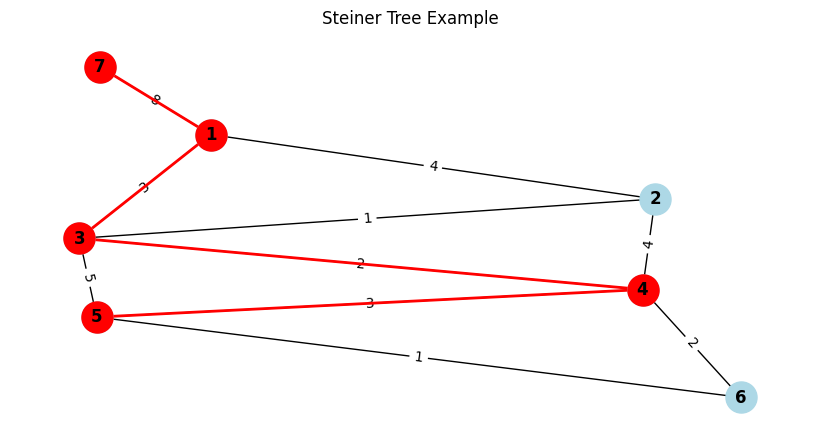

In [37]:
draw_graph(G, steiner_tree)

The use cases of the Steiner Tree Problem is widespread, some examples are electricity distribution and network design. In electricity distribution, the Steiner Tree Problem is used to minimize the total length of power lines connecting a set of power stations. In network design, the Steiner Tree Problem is used to minimize the total cost of connecting a set of locations in a communication network.

Relation to Other Problems:
- The Shortest Path Problem is a special case of the Steiner Tree Problem, where the terminals are two vertices.
- The Steiner Tree Problem is a generalization of the Minimum Spanning Tree Problem, where all vertices are terminals.
- The Steiner Tree Problem is a special case (number of trees = 1) of the Steiner Forest Problem, where multiple trees are allowed to cover the terminals.


# Shortest Path as a Special Case of Steiner Tree

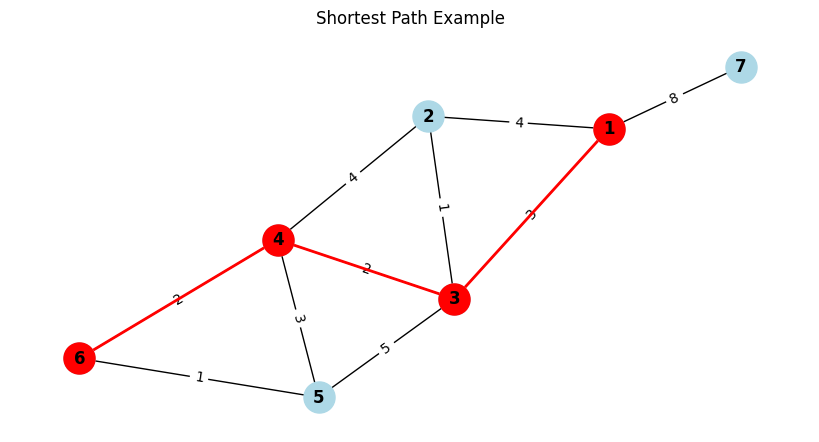

In [38]:
# Shortest path between two nodes {1, 6}
S = {1, 6}
steiner_tree = nx.algorithms.approximation.steiner_tree(G, S)
draw_graph(G, steiner_tree, title="Shortest Path Example")

# Minimum Spanning Tree as Steiner Tree

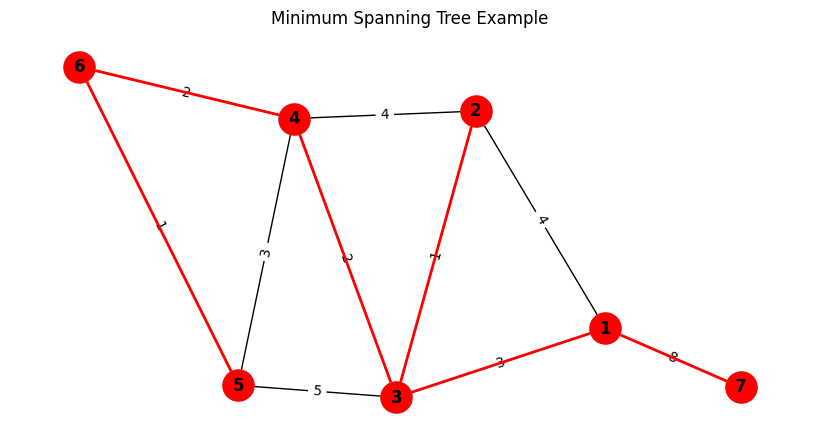

In [39]:
# Minimum spanning tree
S = {1, 2, 3, 4, 5, 6, 7}
steiner_tree = nx.algorithms.approximation.steiner_tree(G, S)
draw_graph(G, steiner_tree, title="Minimum Spanning Tree Example")

# Steiner Tree Brute Force Algorithm

## Complexity

- Generating all subsets: O(2<sup>n</sup>)
- Checking terminals in each subset: O(n)
- Computing minimum spanning tree: O(𝑚logn)
- Total time complexity: O(2<sup>n</sup>.𝑚logn)

The following brute force algorithm for the Steiner Tree Problem has an exponential time complexity of O(2<sup>n</sup>.𝑚logn), where n is the number of vertices  and 𝑚 is the number of edges in the graph. The algorithm iterates over all possible subsets of vertices, checks if the subset contains all terminals, and computes the minimum spanning tree for each valid subset. The exponential time complexity makes the brute force algorithm impractical for large graphs with many vertices.

In [40]:
def steiner_tree_brute_force(G, terminals):
    min_tree = None
    min_weight = float('inf')

    for subset in itertools.chain.from_iterable(itertools.combinations(G.nodes, r) for r in range(len(G.nodes)+1)):
        if set(terminals).issubset(subset):
            subgraph = G.subgraph(subset)
            if nx.is_connected(subgraph):
                tree = nx.minimum_spanning_tree(subgraph)
                weight = tree.size(weight='weight')
                if weight < min_weight:
                    min_tree = tree
                    min_weight = weight

    return min_tree, min_weight

In [41]:
S = {1, 4, 5, 7}

In [42]:
tree, weight = steiner_tree_brute_force(G, S)
print("Exact Steiner Tree:", tree.edges(data=True))
print("Total Weight:", weight)

Exact Steiner Tree: [(1, 3, {'weight': 3}), (1, 7, {'weight': 8}), (3, 4, {'weight': 2}), (4, 5, {'weight': 3})]
Total Weight: 16.0


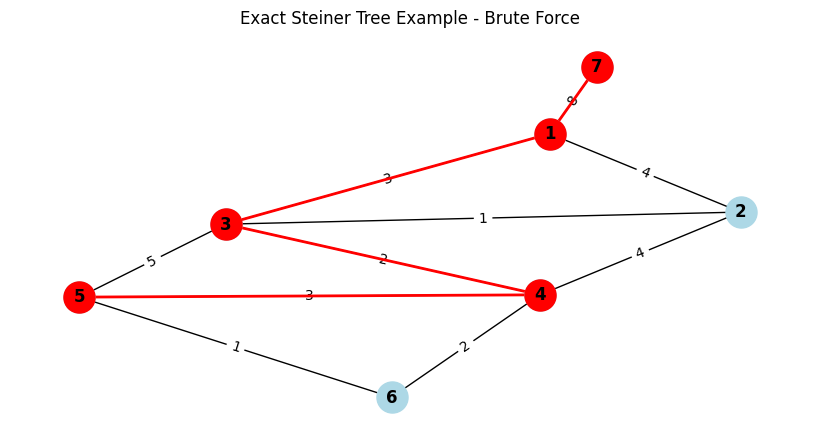

In [43]:
draw_graph(G, tree, title="Exact Steiner Tree Example - Brute Force")

## Aproximation Algorithms
The Steiner Tree Problem is known to be NP-hard, and no polynomial-time exact algorithm is known for general graphs. However, several approximation algorithms can provide near-optimal solutions in polynomial time.

In [44]:
def steiner_tree_dfs(graph, terminals:set):
    def dfs(graph, current, visited, terminals, tree_edges):
        visited.add(current)
        if current in terminals:
            terminals.remove(current)
        
        for neighbor in graph.neighbors(current):
            if not terminals:
                return
            
            if neighbor not in visited:
                tree_edges.append((current, neighbor, graph[current][neighbor]['weight']))
                dfs(graph, neighbor, visited, terminals, tree_edges)
    
    visited = set()
    tree_edges = []
    list_terminals = list(terminals)
    initial_terminal = list_terminals[0]
    
    dfs(graph, initial_terminal, visited, terminals.copy(), tree_edges)

    dfs_steiner_tree = nx.Graph()
    dfs_steiner_tree.add_weighted_edges_from(tree_edges)
    return dfs_steiner_tree

In [45]:
dfs_steiner_tree = steiner_tree_dfs(G, S.copy())

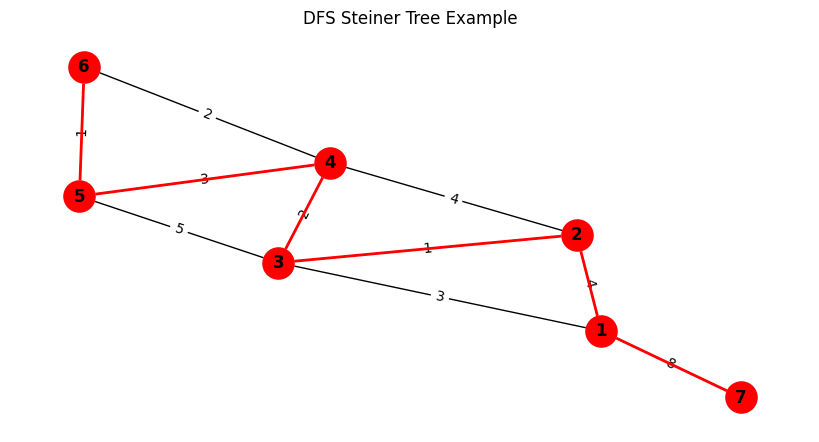

In [46]:
draw_graph(G, dfs_steiner_tree, title="DFS Steiner Tree Example")

We can try and improve the previous dfs algorithm by using a greedy startegy. Where we start by connecting the terminals with the shortest path and then we add the shortest path that connects the terminals with the rest of the vertices. We repeat this process until we connect all the terminals.

In [47]:
def steiner_tree_dfs_greedy(graph, terminals:set):
    def dfs(graph, current, visited, terminals, tree_edges):
        visited.add(current)
        if current in terminals:
            terminals.remove(current)

        neighbors_heap = []

        for neighbor in graph.neighbors(current):
            if neighbor not in visited:
                weight = graph[current][neighbor]['weight']
                heapq.heappush(neighbors_heap, (weight, neighbor))
        
        while neighbors_heap:
            if not terminals:
                return
            
            weight, neighbor = heapq.heappop(neighbors_heap)

            if neighbor not in visited:
                tree_edges.append((current, neighbor, weight))
                dfs(graph, neighbor, visited, terminals, tree_edges)
    
    visited = set()
    tree_edges = []
    list_terminals = list(terminals)
    initial_terminal = list_terminals[0]
    
    dfs(graph, initial_terminal, visited, terminals.copy(), tree_edges)

    dfs_steiner_tree = nx.Graph()
    dfs_steiner_tree.add_weighted_edges_from(tree_edges)
    return dfs_steiner_tree

In [48]:
greedy_dfs_steiner_tree = steiner_tree_dfs_greedy(G, S.copy())

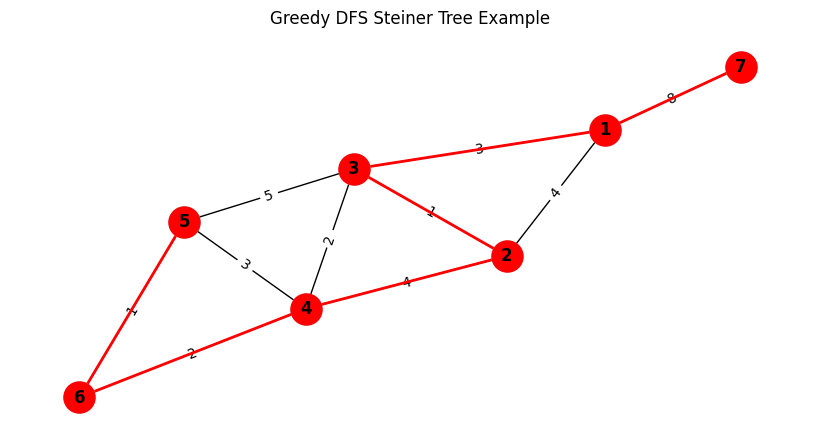

In [49]:
draw_graph(G, greedy_dfs_steiner_tree, title="Greedy DFS Steiner Tree Example")

The aproximations produced by this algorithms are not guaranteed to be optimal. However, they are much faster than the brute force algorithm and can provide good enough solutions for large graphs.

### Mehlhorn Algorithm - Best aproximation algorithm for the Steiner Tree Problem

The following method from the networkx library can be used to aproximate the steiner tree solution in a graph.
The method uses the mehlhorn algorithm to solve the steiner tree problem in a graph. The mehlhorn algorithm is an aproximation algorithm, it does not guarantee the optimal solution but it is very fast and gives a good solution in most cases. It's an improvement to the Kou algorithm which is also an aproximation algorithm but it is slower than the mehlhorn algorithm.

The algorithm runs in O(E+VlogV) time in the worst case, where E is the set of all edges and V the set of all vertices in the graph.

In [50]:
steiner_tree = nx.algorithms.approximation.steiner_tree(G, S)

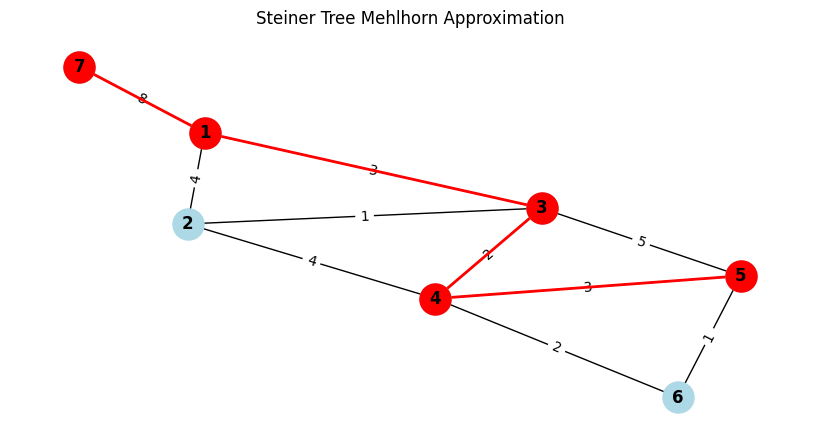

In [51]:
draw_graph(G, steiner_tree, title="Steiner Tree Mehlhorn Approximation")

Mehlhorn, k. (1988). A faster approximation algorithm for the Steiner problem in graphs. Information Processing Letters, 27(3), 125-128. https://doi.org/10.1016/0020-0190(88)90066-X
Schäfer, G. (2008). Steiner Forest. In: Kao, MY. (eds) Encyclopedia of Algorithms. Springer, Boston, MA. https://doi.org/10.1007/978-0-387-30162-4_402
Kruskal’s Minimum Spanning Tree (MST) Algorithm: https://www.geeksforgeeks.org/kruskals-minimum-spanning-tree-algorithm-greedy-algo-2/